# Pima Indians Diabetes Classification - Toby Liang

## Importing Essential Libraries

In [87]:
# Import essential libraries
import pandas as pd
import numpy as np

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

## Data Summary

In [88]:
# Load dataset
dataset = pd.read_csv("./data/diabetes.csv")

# Feature renaming
dataset.columns = ["pregnancies", "glucose", "blood_pressure", "skin_thickness", "insulin", "body_mass_index", "pedigree", "age", "label"]

# Get first 5 examples
dataset.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,body_mass_index,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


All features are quantitative so no one-hot encoding is required.  The data, however, is not normalized or standardized so some preprocessing will need to be done.  Features such as insulin and skin thickness have 0 values which does not make sense.

### Check for NaN Values

In [89]:
# Check for NaN values
dataset.isnull().sum()

pregnancies        0
glucose            0
blood_pressure     0
skin_thickness     0
insulin            0
body_mass_index    0
pedigree           0
age                0
label              0
dtype: int64

Data does not contain any NaN values.

### Check for 0 Values

In [90]:
# Check for 0 values
(dataset == 0).astype(int).sum()

pregnancies        111
glucose              5
blood_pressure      35
skin_thickness     227
insulin            374
body_mass_index     11
pedigree             0
age                  0
label              500
dtype: int64

Data contains 0 values for features that can not be 0 such as glucose, blood pressure, skin thickness, insulin, and body mass index.  These 0 values will be replaced by the mean.

### Check for Duplicates

In [91]:
# Check for duplicate values
dataset.duplicated().value_counts()

False    768
dtype: int64

### Get Unique Labels

In [92]:
dataset.label.unique()

array([1, 0])

Labels are binary so this is a binary classification problem.  (0 meaning no diabetes and 1 meaning diabetes)

## Data Preprocessing

In [94]:
dataset[dataset["glucose"] == 0

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
738    False
739    False
740    False
741    False
742    False
743    False
744    False
745    False
746    False
747    False
748    False
749    False
750    False
751    False
752    False
753    False
754    False
755    False
756    False
757    False
758    False
759    False
760    False
761    False
762    False
763    False
764    False
765    False
766    False
767    False
Name: glucose, Length: 768, dtype: bool

In [86]:
from sklearn.preprocessing import scale

# Replace zeros with means
non_zero_cols = ["glucose", "blood_pressure", "skin_thickness", "insulin", "body_mass_index"]
for col in non_zero_cols:
    copy_dataset = dataset.drop(dataset[dataset[col] == 0].index)
    mean = copy_dataset[col].mean()
    dataset[col].mask(dataset[col] == 0, mean, inplace=True)
    
# Zero replace sanity check
print((dataset == 0).astype(int).sum())
    
# Feature-label splitting
features = dataset.drop("label", axis=1)
labels = dataset[["label"]]

# Data standardization
features[features.columns] = scale(features[features.columns])

# Data summary
features.describe().T.round(2)

pregnancies        111
glucose              0
blood_pressure       0
skin_thickness       0
insulin              0
body_mass_index      0
pedigree             0
age                  0
label              500
dtype: int64


,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,-0.0,1.0,-1.14,-0.84,-0.25,0.64,3.91
glucose,768.0,-0.0,1.0,-2.55,-0.72,-0.15,0.61,2.54
blood_pressure,768.0,0.0,1.0,-4.00,-0.70,-0.02,0.63,4.10
skin_thickness,768.0,0.0,1.0,-2.52,-0.47,0.00,0.32,7.95
insulin,768.0,-0.0,1.0,-1.67,-0.40,-0.00,-0.00,8.13
body_mass_index,768.0,0.0,1.0,-2.08,-0.72,-0.01,0.60,5.04
pedigree,768.0,0.0,1.0,-1.19,-0.69,-0.30,0.47,5.88
age,768.0,0.0,1.0,-1.04,-0.79,-0.36,0.66,4.06


## Exploratory Data Analysis

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

### Label Counts

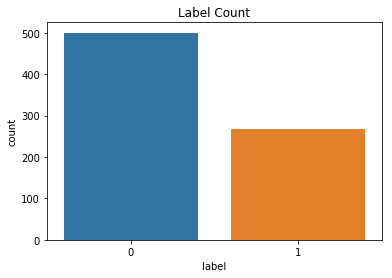

In [64]:
# Label count
plt.title("Label Count")
sns.countplot(labels.label)
plt.show()

There are significantly more subjects without diabetes than with diabetes as shown above.

### Feature-Label Correlation

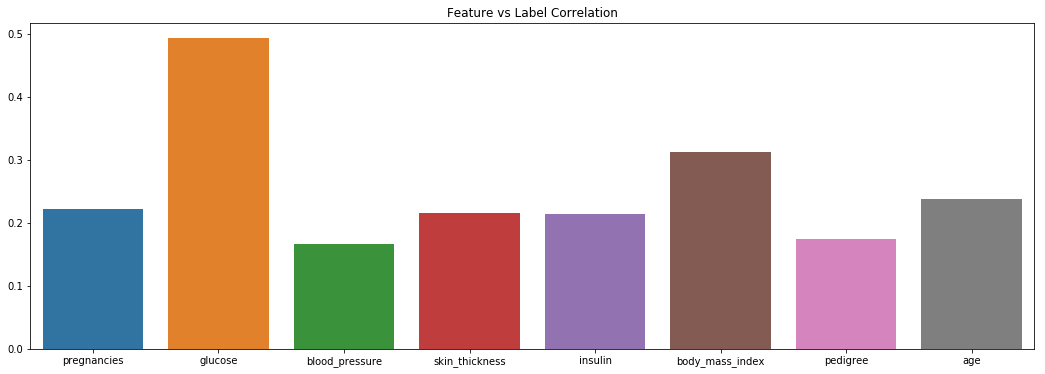

In [65]:
# Getting feature-label correlation
correlation = dataset.corr()
label_correlation = correlation["label"]
label_correlation.drop("label", inplace=True)

# Plot
plt.figure(figsize=(18, 6))
plt.title("Feature vs Label Correlation")
sns.barplot(label_correlation.index, label_correlation.values)
plt.show()

Glucose amount has the greatest correlation with diabetes with a value close to 0.5.  Body mass index also has a fairly high correlation while most other features have a correlation between 0.15 and 0.3.  It was surprising to see that insulin had such a low correlation.

### Feature Distributions

[]

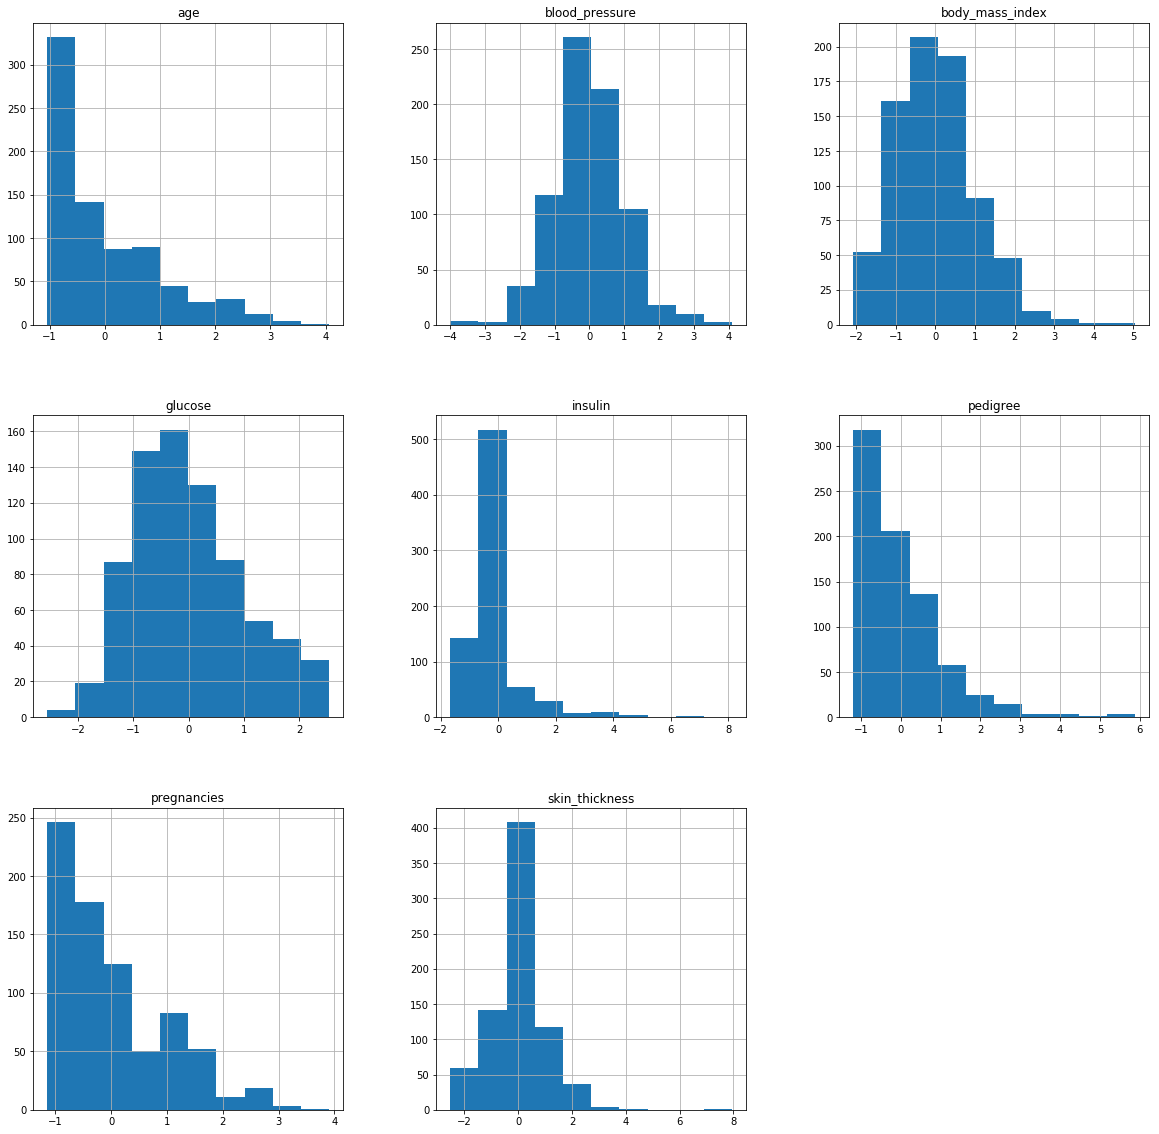

In [66]:
# Visualizing feature distributions
features.hist(figsize=(20,20))
plt.plot()

All features except for skin thickness are skewed to the right with the most skewed being age, pedigree, and pregnancies.

## Models

### Utility functions

In [67]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def split_data():
    return train_test_split(features, labels, train_size=0.8, shuffle=True)

def avg_acc(function, iterations):
    sum = 0.0
    for i in range(iterations):
         sum += function()
    print("Avg Accuracy: {}".format(sum / iterations))

def nn_plot_hist(hist):
    # Plot loss
    figure, (loss, acc) = plt.subplots(1, 2, figsize=(8,4))
    loss.set_title("Loss")
    loss.plot(hist.history["loss"])
    loss.plot(hist.history["val_loss"])

    # Plot accuracy
    acc.set_title("Accuracy")
    acc.plot(hist.history["acc"])
    acc.plot(hist.history["val_acc"])
    plt.show()
    
def nn_k_fold_validation(k=3, should_plot=False, lr=0.0004, dp=0.25, epochs=100, batch_size=32):
    train_data, test_data, train_labels, test_labels = split_data()
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    
    avg_acc = 0
    for i, (train_indexes, val_indexes) in enumerate(skf.split(train_data, train_labels)):
        # Define data, labels, val_data, and val_labels
        data = train_data.values[train_indexes]
        labels = train_labels.values[train_indexes]
        val_data = train_data.values[val_indexes]
        val_labels = train_labels.values[val_indexes]
        
        # Create new model
        model = Model(lr=lr, dp=dp)
                
        # Fit and plot model
        hist = model.fit(data, labels, (val_data, val_labels), epochs=epochs, batch_size=batch_size)
        if should_plot:
            nn_plot_hist(hist)
        avg_acc += hist.history["val_acc"][-1]
        
    avg_acc /= k
    return avg_acc
    
def nn_rand_tune(n_iter=5):
    # Split data
    train_data, test_data, train_labels, test_labels = split_data()
    
    # Initialize model and tuner
    model = Model()
    tuner = KerasClassifier(build_fn=model.create_model)
    
    # Define hyperparameters
    lr=[0.1, 0.15, 0.2]
    dp=[0.2, 0.3, 0.4]
    batch_size = [16, 32, 64]
    num_n = [16, 32, 64]
    
    # Run random search
    hyperparams = dict(lr=lr, dp=dp, batch_size=batch_size, num_n=num_n)
    random_search = RandomizedSearchCV(estimator=tuner, param_distributions=hyperparams, n_iter=n_iter)
    results = random_search.fit(train_data, train_labels)
    
    
    results_df = pd.DataFrame(results.cv_results_).sort_values("rank_test_score")
    print(results_df)
    
def nn_iter_tune(upper_bound, lower_bound, hyperparam_name, scaler=10, k=3, is_exp=False):
    curr_val = upper_bound
    val_lst = []
    acc_lst = []
    while curr_val >= lower_bound:
        val_lst.append(curr_val)
        
        acc = nn_k_fold_validation(k, **{hyperparam_name: curr_val})
        acc_lst.append(acc)
        print("Accuracy {} at value {}".format(acc, curr_val))
        
        if is_exp:
            curr_val /= scaler
        else:
            curr_val -= scaler
            
    plt.plot(val_lst, acc_lst, "o-")
    if is_exp:
        plt.xscale("log", basex=scaler)
    plt.show()

### Support Vector Machine

In [72]:
from sklearn.svm import SVC

def train_svm():
    # Split data
    train_data, test_data, train_labels, test_labels = split_data()
    
    # Initialize and fit model
    model = SVC()
    model.fit(train_data, train_labels)
    
    # Return accuracy
    return model.score(test_data, test_labels)

avg_acc(train_svm, iterations=20)

Avg Accuracy: 0.7467532467532468


### Neural Network

In [15]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [16]:
class Model():
    def __init__(self, lr=1e-1, dp=0, num_n=16):
        self.model = self.create_model(lr, dp, num_n)
        
    def create_model(self, lr, dp, num_n):
        model = Sequential()
        
        # Hidden layer
        model.add(Dense(num_n, input_dim=8))
        model.add(BatchNormalization(axis=1))
        model.add(Activation("relu"))
        model.add(Dropout(rate=dp))
        
        # Hidden layer
        model.add(Dense(num_n))
        model.add(BatchNormalization(axis=1))
        model.add(Activation("relu"))
        model.add(Dropout(rate=dp))
        
        # Output layer
        model.add(Dense(1))
        model.add(BatchNormalization(axis=1))
        model.add(Activation("sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr), metrics=["accuracy"])
        
        return model
        
    def fit(self, train_data, train_labels, validation_data=None, epochs=100, batch_size=32):
        history = self.model.fit(train_data, 
                                 train_labels, 
                                 validation_data=validation_data,
                                 validation_split=0.2,
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 verbose=0)
        return history
        
    def score(self, test_data, test_labels):
        return self.model.evaluate(test_data, test_labels, verbose=0)[1]

In [17]:
# nn_iter_tune(50, 10, "batch_size", scaler=5, k=10, is_exp=False)

In [18]:
# nn_k_fold_validation(k=15, should_plot=True, lr=0.0004, dp=0.25, batch_size=32)

In [73]:
def evaluate_model():
    train_data, test_data, train_labels, test_labels = split_data()
    model = Model(0.0004, 0.25, 16)
    model.fit(train_data, train_labels)
    return model.score(test_data, test_labels)
avg_acc(evaluate_model, iterations=20)

Avg Accuracy: 0.7525974015136818
